# Financial Backtesting Engine Example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

A simple program capable of backtesting trading strategies on a variety of financial data.  For the sake of example, ETF data is being used here.

In [2]:
# Load data
base_path = 'C:/Users/jacke/Documents/Data Projects/'

filenames = ["MutualFund prices - A-E.csv", "MutualFund prices - F-K.csv", "MutualFund prices - L-P.csv", "MutualFund prices - Q-Z.csv", "MutualFunds.csv", "ETF prices.csv", "ETFs.csv"]

price_data = pd.DataFrame()

price_data = pd.read_csv(base_path + filenames[5])
data = price_data.pivot(index='price_date', columns='fund_symbol', values='adj_close')

Defining a strategy, could be anything; as simple or complex as desired

In [3]:
# I don't know how to algo trade
def moving_average_crossover_strategy(data, target_etf, short_window, long_window):
    if target_etf not in data.columns:
        raise KeyError(f"ETF '{target_etf}' not found in the data columns.")
    
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0

    # Create short simple moving average
    signals['short_mavg'] = data[target_etf].rolling(window=short_window, min_periods=1, center=False).mean()

    # Create long simple moving average
    signals['long_mavg'] = data[target_etf].rolling(window=long_window, min_periods=1, center=False).mean()

    # Create signals
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()

    return signals

Backtesting function

In [4]:
def backtest_strategy(price_data, signals, target_etf, initial_capital=10000.0):
    positions = pd.DataFrame(index=signals.index).fillna(0.0)
    positions[target_etf] = 100 * signals['signal']  # Buy 100 shares

    portfolio = positions.multiply(price_data[target_etf], axis=0)
    pos_diff = positions.diff()

    # Add `holdings` to portfolio
    portfolio['holdings'] = (positions.multiply(price_data[target_etf], axis=0)).sum(axis=1)

    # Add `cash` to portfolio
    portfolio['cash'] = initial_capital - (pos_diff.multiply(price_data[target_etf], axis=0)).sum(axis=1).cumsum()

    # Add `total` to portfolio
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']

    return portfolio

Running the numbers, on SPY in this example

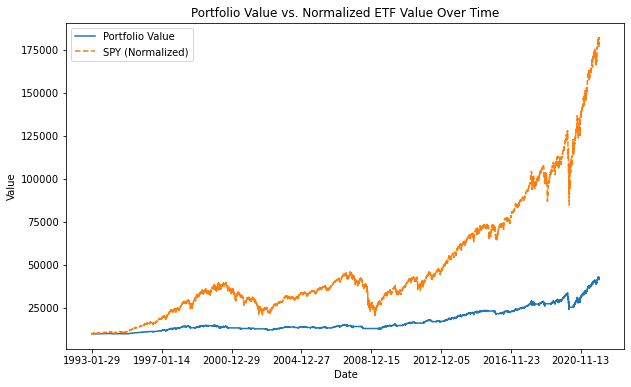

In [5]:
# Define the target ETF
target_etf = 'SPY'

# Apply the strategy
signals = moving_average_crossover_strategy(data, target_etf, short_window=40, long_window=100)
portfolio = backtest_strategy(data, signals, target_etf)

# Normalize the ETF prices to the starting portfolio value
initial_value = portfolio['total'].iloc[0]
normalized_etf = data[target_etf] / data[target_etf].iloc[0] * initial_value

# Plot the portfolio value and normalized ETF value over time
plt.figure(figsize=(10, 6))
portfolio['total'].plot(label='Portfolio Value')
normalized_etf.plot(label=f'{target_etf} (Normalized)', linestyle='--')
plt.title('Portfolio Value vs. Normalized ETF Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

It seems the strategy successfully gave up the majority of gains in exchange for slightly less volitility.

In [6]:
def calculate_performance_metrics(portfolio):
    returns = portfolio['total'].pct_change()
    cumulative_returns = (1 + returns).cumprod() - 1
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)  # Assuming daily returns

    # Calculate maximum drawdown
    rolling_max = portfolio['total'].cummax()
    drawdown = portfolio['total'] / rolling_max - 1
    max_drawdown = drawdown.min()

    return cumulative_returns[-1], sharpe_ratio, max_drawdown

# Calculate metrics
cumulative_return, sharpe_ratio, max_drawdown = calculate_performance_metrics(portfolio)

print(f"Cumulative Return: {cumulative_return:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}")

Cumulative Return: 3.15
Sharpe Ratio: 0.57
Max Drawdown: -0.28


As we can see from the Sharpe ratio, I should not be utilizing this strategy anytime soon.

The backtesting engine itself, however, worked, and saved my portfolio a lot of future pain.